# Homework 4

In [1]:
import pandas as pd

We need bank-full.csv.

In this dataset the target variable is y variable - has the client subscribed a term deposit or not.

In [2]:
#!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
#unzip bank+marketing.zip 
#unzip bank.zip

## Dataset preparation

For the rest of the homework, you'll need to use only these columns:

- 'age',
- 'job',
- 'marital',
- 'education',
- 'balance',
- 'housing',
- 'contact',
- 'day',
- 'month',
- 'duration',
- 'campaign',
- 'pdays',
- 'previous',
-'poutcome',
- 'y'
Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [3]:
df = pd.read_csv("bank/bank-full.csv", sep=";")

In [4]:
df = df[['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome','y']]

In [5]:
df_new = df.copy()

In [6]:
df_new.y = (df_new.y == "yes").astype('int')
print(df_new['y'].unique())

[0 1]


In [7]:
from sklearn.model_selection import train_test_split 

In [8]:
df_full_train, df_test = train_test_split(df_new, test_size = 0.2, random_state = 1)

In [9]:
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [10]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train.y
y_val = df_val.y
y_test = df_test.y

del df_train['y']
del df_val['y']
del df_test['y']

__Question 1: ROC AUC feature importance__

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the <code>AUC</code> with the <code>y</code> variable as ground truth.
Use the training dataset for that
If your <code>AUC</code> is <code>< 0.5 </code>, invert this variable by putting "-" in front

(e.g.<code> -df_train['engine_hp'] </code>)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- balance
- day
- duration
- previous

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


In [12]:
features = ["balance", "day", "duration", "previous"]

all_auc_scores = {}
for fea in features:
    X_train_fea = df_train.copy()
    X_train_fea = X_train_fea[fea]
    X_val_fea = df_val.copy()
    X_val_fea = X_val_fea[fea]
    model = LogisticRegression()
    model.fit(X_train_fea.values.reshape(-1,1),y_train)
    y_pred_fea = model.predict_proba(X_val_fea.values.reshape(-1,1))[:,1]
    auc_score = roc_auc_score(y_val, y_pred_fea)
    print(auc_score)
    if auc_score < 0.5:
        auc_score  = - auc_score
    all_auc_scores[fea] = auc_score
    
    
best_auc_score = max(all_auc_scores, key=all_auc_scores.get)

print(f"The variable with the highest AUC is: \033[1m{best_auc_score}\033[0m")
print(f"AUC scores for each variable: \033[1m{all_auc_scores}\033[0m")   


0.5995068851725284
0.5352198426324892
0.7965344730967409
0.607255799705406
The variable with the highest AUC is: duration
AUC scores for each variable: {'balance': 0.5995068851725284, 'day': 0.5352198426324892, 'duration': 0.7965344730967409, 'previous': 0.607255799705406}


# Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

<code> LogisticRegression(solver='liblinear', C=1.0, max_iter=1000) </code>
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.9

In [13]:
from sklearn.feature_extraction import DictVectorizer

In [14]:
df_train_oh = df_train.copy()
df_val_oh = df_val.copy()

df_train_oh = df_train_oh.to_dict(orient = "records")
df_val_oh = df_val_oh.to_dict(orient = "records")

dv = DictVectorizer(sparse = False)
dv.fit(df_train_oh)

df_train_ohh = dv.transform(df_train_oh)
df_val_ohh = dv.transform(df_val_oh)

model =  LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(df_train_ohh, y_train)

y_val_pred_ohh = model.predict_proba(df_val_ohh)[:,1]
auc_score = roc_auc_score(y_val, y_val_pred_ohh)

print(f"The auc score is \033[1m{auc_score:.2f}\033[0m")

The auc score is 0.90


## Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.265
- 0.465
- 0.665
- 0.865

In [15]:
import numpy as np
print(np.unique(y_val))

[0 1]


In [16]:
scores = []
start = 0.0
step = 0.01
stop = 1.0

thresholds = np.arange(start, stop + step, step).tolist()
#print(thresholds)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_val_pred_ohh >= t)
    predict_negative = (y_val_pred_ohh <t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp =  (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    prec = tp/(tp+fp)
    rec = tp/(tp+fn)

    scores.append((t, prec, rec))


#print(scores)
df_scores =  pd.DataFrame(scores, columns=["thresholds", "precision", "recall"])

C:\Users\Kuzey\AppData\Local\Temp\ipykernel_10140\1266337747.py:22: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp/(tp+fp)


In [17]:
df_scores.head(10)

,thresholds,precision,recall
0,0.00,0.121433,1.000000
1,0.01,0.135095,0.996357
2,0.02,0.158820,0.995446
3,0.03,0.186417,0.989982
4,0.04,0.219392,0.972678
5,0.05,0.254122,0.954463
6,0.06,0.289116,0.928962
7,0.07,0.317268,0.905282
8,0.08,0.342766,0.882514
9,0.09,0.366563,0.860656


Text(0.5, 0, 'Threshold')

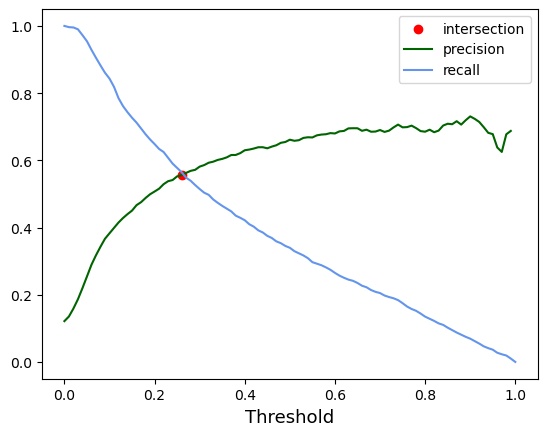

In [42]:
from matplotlib import pyplot as plt
df_scores['difference'] = abs(df_scores['precision'] -df_scores['recall'])
min_dif_index = df_scores['difference'].idxmin()
x = df_scores.thresholds.iloc[min_dif_index]
y = df_scores.precision.iloc[min_dif_index]
plt.scatter(x, y, color = "red", label="intersection")
plt.plot(df_scores["thresholds"], df_scores["precision"], label = "precision", color = "darkgreen")
plt.plot(df_scores["thresholds"], df_scores["recall"], label = "recall", color = "cornflowerblue")
plt.legend()
plt.xlabel("Threshold", fontsize = 13)

In [38]:
df_scores['difference'] = abs(df_scores['precision'] - df_scores['recall'])

print(df_scores['difference'].idxmin())

inter_thres = df_scores["thresholds"].iloc[min_dif_index]

26


In [39]:
print(f"The intersection point is {inter_thres}.")

The intersection point is 0.26.
